In [1]:
from IPython.core.display import HTML
HTML('<iframe src=http://fivethirtyeight.com/features/statisticians-found-one-thing-they-can-agree-on-its-time-to-stop-misusing-p-values/?ex_cid=story-twitter width=700 height=550></iframe>')

# Statistical Inference.

**Descriptive statistics** describe a sample, **inferential statistics** infer predictions about a population.

**Statistical inference** deals with understanding the quality of parameter estimates of a sample.

Statistical inference produces **statistical propositions** about:

+ point estimates (a particular value that best approximates some parameter of interest), 
+ confidence intervals (or set estimate) or 
+ the rejection of a hypothesis.

Statistical inference is based on assumptions related to a statistical model or sampling process. Correct inference requires these assumptions to be correct.

In this session we will develop the **frequentist inference paradigm**. It bases the production of propositions by considering repeated sampling of a population.** P-values and confidence intervals are its most common propositions**.

### Frequentist paradigm assumptions vs Bayesian paradigm assumptions.

There are two main approaches to statistical inference: Frequentist and Bayesian.

Frequentist assumptions:

+ Data are a repeatable random sample - there is a frequency.
+ Underlying assumptions remain constant during this repeatable process; 
+ Parameters are fixed.

Bayesian assumptions:

+ Data are observed from a realized sample.
+ Parameters are unknown and described probabilistically.
+ Data are fixed.

 

### Reminder

After exploring the data and computing some descriptive statistics from the National Survey of Family Growth (NSFG) we have seem some **apparent effects** that seem to support a hypothesis: The mean pregnant lenght for first babies is larger than for other babies.

But there are still **important** questions to be solved:

+ What is the probability that **a result is caused by chance** (due to the particular sample)? 
+ Is it **statistically significant**?
+ Is it **relevant**?

In [2]:
file = open('files/2002FemPreg.dat', 'r')

def chr_int(a):
    if a == '  ':
        return 0
    else:
        return int(a)
        
preg=[]
for line in file:
    lst  = [int(line[:12]), int(line[274:276]), int(line[276]), \
                 chr_int(line[277:279]), float(line[422:440])]
    preg.append(lst)
    
import pandas as pd
df = pd.DataFrame(preg)
df.columns = ['caseid', 'prglength', 'outcome', 'birthord', 'finalwgt']
firstbirth = df[(df.outcome == 1) & (df.birthord == 1)]
othersbirth = df[(df.outcome == 1) & (df.birthord >= 2)]

# descriptive statistics
muf = firstbirth['prglength'].mean()
stdf = firstbirth['prglength'].std()

print 'First babies mean:',muf, 'STD:',stdf

First babies mean: 38.6009517335 STD: 2.79190141467


In [3]:
muo = othersbirth['prglength'].mean()
stdo = othersbirth['prglength'].std()
print 'Other babies mean:', muo, 'STD:',stdo

Other babies mean: 38.5229144667 STD: 2.61585235044


## Variability in estimates.

Descriptive statistics are not equal to the *truth* but they are better as more data become available. 

Moreover, they vary from one sample to another. It would be useful to know how variable they are from one sample to another!

### Point estimates

Let's suppose that we want to estimate the *population mean* based on the sample. 

The most intuitive
way to go about doing this is to simply take the *sample mean*. The sample mean is a **point estimate of the population mean**. If we can only choose one value to estimate the population mean, this is our best guess.

We can generate point estimates of other population parameters, such as the *population median* or *population standard deviation*.

Estimates generally vary from one sample to another, and this sampling variation suggests our estimate may be close, but it will not be exactly equal to the parameter.
We can see this by plotting a **running mean** from our data.

In [4]:
%matplotlib inline

import matplotlib.pylab as plt
import numpy as np

running_mean = np.array([0.0] * (len(firstbirth['prglength'])+1))
running_mean[0] = firstbirth['prglength'].values[0]

i = 1
for x in firstbirth['prglength']:
    running_mean[i] = running_mean[i-1] + x
    i += 1
    
running_mean = running_mean / np.array(range(1,len(firstbirth['prglength'])+2))
mean = running_mean[len(firstbirth['prglength'])-1]
print mean

38.6009517335


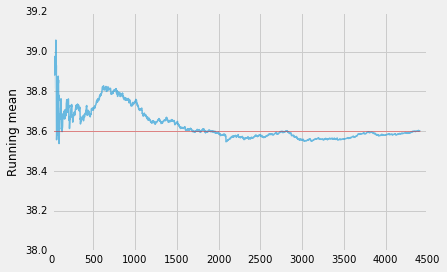

In [5]:
with plt.style.context('fivethirtyeight'):
    plt.plot(running_mean, lw=1.5, alpha=0.7)
    plt.ylabel('Running mean')
    plt.plot([0, len(firstbirth['prglength'])-1], [mean, mean], 'r-', lw=0.5, alpha=0.7)

plt.show()

It is important to note that even after 1000 samples, the mean can substantially vary. So, if we get several samples from a population we can build the *estimate distribution*. 

### Sample mean distribution

In our case, if we consider the full dataset a population, we can built the **empirical distribution of the sample mean** for a given number of observations (f.e. samples with 1000 observations).

In [6]:
df = firstbirth['prglength']     # population

N_test = 10000                   # number of different samples from the population
elements = 1000                  # number of observations in each sample
means = [0] * N_test             # samples' mean array

for i in range(N_test):          # sample generation
    rows = np.random.choice(df.index.values, elements)
    sampled_df = df.ix[rows]
    means[i]=sampled_df.mean()

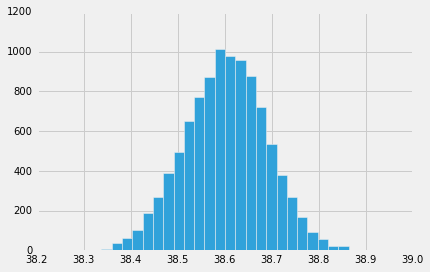

In [7]:
with plt.style.context('fivethirtyeight'):
    plt.hist(means,bins=30)
    
plt.show()

We can use this empirical distribution to give sound answers to a series of interesting questions:

+ What is the uncertainty of the sample mean?
+ What is the probability of getting a sample mean $\geq$ than $x$? Or in other words, is a given sample mean probable?
+ Etc. 

That is, we can produce statistical propositions!

<div class = "alert alert-success" style = "border-radius:10px;border-width:3px;border-color:darkgreen;font-family:Verdana,sans-serif;font-size:16px;">The **sampling distribution** represents the distribution of a point estimate based
on samples of a *fixed size* from a certain population. 

It is useful to think of a particular
point estimate as being drawn from such a distribution. Understanding the concept of a sampling distribution is central to understanding statistical inference.
</div>   

### Standard error of the mean

If we do not have access to the population, the sampling distribution can not be built empirically.

It can be mathematically shown that given $n$ independent observations $\{ x_i \}_{i=1,..,n}$ from a population with a standard deviation $\sigma_x$, the standard deviation of the sample mean $\sigma_{\bar{x}}$, or **standard error** is:

$$ SE = \frac{\sigma_{x}}{\sqrt{n}} $$

This allows **to estimate the standard deviation of the sample mean** if we don't perform the simulation process (f.e. because we have no access to the population).

Usually, $\sigma_x$ is not known and it is substituted by its empirical estimate (that is sufficiently good of $n>30$ and the population distribution is not skewed).

In [8]:
import math

rows = np.random.choice(df.index.values, 1000)
sampled_df = df.ix[rows]

sigma_mean = df.std()/math.sqrt(1000)
est_sigma_mean = sampled_df.std()/math.sqrt(1000)

print 'Standard error of the mean using the real SE of the population  :', sigma_mean
print 'Standard error using an emprirical estimate of the population SE:', est_sigma_mean
print 'Estimation of the standard error by simulation                  :', np.array(means).std()

Standard error of the mean using the real SE of the population  : 0.08828767473
Standard error using an emprirical estimate of the population SE: 0.0851262913881
Estimation of the standard error by simulation                  : 0.0876198662231


By simulation, we could also quantify the standard deviation of other estimates: median, standard deviation, etc. But this is not a real alternative for real problems because we do not have access to the population. Moreover, we do not know any simple mathematical approximation to these values.

### Example: Is this coin biased?

A statistical statement appeared in “The Guardian" on Friday January 4, 2002:

>When spun on edge 250 times, a Belgian one-euro coin came up heads 140 times and tails 110. ‘It looks very suspicious to me,’ said Barry Blight, a statistics lecturer at the London School of Economics. ‘If the coin were unbiased, the chance of getting a result as extreme as that would be less than 7%.’

But do these data give evidence that the coin is biased rather than fair?

In [9]:
mean = 140.0/250
print mean

0.56


What is the probability of getting this result in the case of a fair coin?

In this case we know how to **simulate the events** and we can built the sample mean distribution.

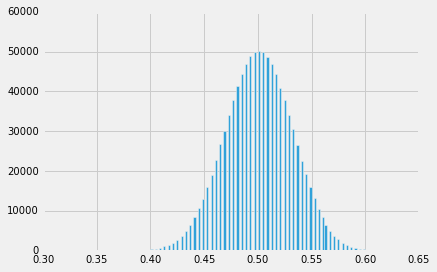

In [10]:
import numpy as np
n = 1000000

means = [0]*n

for i in range(n):
    trials = np.random.randint(2,size=250)
    means[i] = trials.mean()

with plt.style.context('fivethirtyeight'):
    plt.hist(means,bins=150)

    
plt.show()

Once we have the sample mean distribution, we can compute the probability of getting our result (or even a more extreme result).

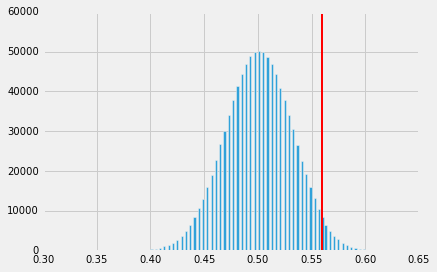

In [11]:
with plt.style.context('fivethirtyeight'):
    plt.hist(means,bins=150)
    plt.axvline(x=0.56, color = 'r', linewidth=2)
    plt.draw()
    
plt.show()

In [12]:
M=0.0
for i in range(n):
    if (means[i] >= 0.56): M += 1
print M/n

0.033312


The probability of getting a sample mean $\geq 0.56$  is $3 \%$ in the case of a fair coin. 

Depending on our beliefs, we can now to give an answer to the original question. For example: I consider that getting a sample mean with a probability of $3\%$ is not sufficient to consider that the coin is not fair.

### Bootstraping

In statistics, bootstrapping can refer to any test or metric that relies on **random sampling with replacement**. 

Bootstrapping allows assigning measures of accuracy (defined in terms of bias, variance, etc.) to sample estimates (mean, median, SE, etc). 

The simplest bootstrap method involves taking an original data set of $N$ values, and sampling from it to form a new sample (called a 'resample' or bootstrap sample) that is also of size $N$. 

The bootstrap sample is taken from the original using sampling with replacement so, assuming $N$ is sufficiently large, for all practical purposes there is virtually zero probability that it will be identical to the original "real" sample. 

This process is repeated a large number of times (typically 1,000 or 10,000 times), and for each of these bootstrap samples we compute the desired estimate (each of these are called bootstrap estimates). We now have a histogram of bootstrap estimates. This provides an estimate of the shape of the distribution of the mean from which we can answer questions about how much the mean varies.

(Source: Wikipedia)



38.596535 0.615298093427


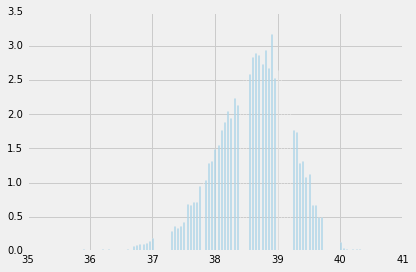

In [13]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

xbar = [0]*10000
X = np.array(df)

for i in range(10000):
    sample = [X[_] for _ in np.random.randint(len(X), size=20)]
    xbar[i] = np.mean(sample)

print np.mean(xbar), np.std(xbar)
with plt.style.context('fivethirtyeight'):    
    plt.hist(xbar, bins=450, normed=True)

## Exercise

Let's consider a dataset of accidents in Barcelona in 2013. This dataset can be download from OpenDataBCN website (http://opendata.bcn.cat/), Barcelona's City Hall open data service. Each register in the dataset represents an accident by a series of features: weekday, hour, address, number of dead and injured people, etc. This dataset will represent our population: the set of all reported trac accidents in Barcelona during 2013.
In https://dieguico.cartodb.com/viz/50b06d8c-13ab-11e5-8619-0e4fddd5de28/public_map you can visualize a map of accidents in the city of Barcelona by hour of day, and by day of week.

In [14]:
import matplotlib.pylab as plt
from matplotlib import cm
import math
import pandas as pd
import numpy as np
import random

%matplotlib inline 
plt.style.use('seaborn-whitegrid')
plt.rc('text', usetex=True)
plt.rc('font', family='times')
plt.rc('xtick', labelsize=10) 
plt.rc('ytick', labelsize=10) 
plt.rc('font', size=12) 

data = pd.read_csv("files/ACCIDENTS_GU_BCN_2013.csv", encoding='latin-1')
print data.columns

Index([u'Número d'expedient', u'Codi districte', u'Nom districte', u'NK barri',
       u'Nom barri', u'Codi carrer', u'Nom carrer', u'Num postal caption',
       u'Descripció dia setmana', u'Dia de setmana', u'Descripció tipus dia',
       u'NK Any', u'Mes de any', u'Nom mes', u'Dia de mes', u'Hora de dia',
       u'Descripció torn', u'Descripció causa vianant', u'Número de morts',
       u'Número de lesionats lleus', u'Número de lesionats greus',
       u'Número de víctimes', u'Número de vehicles implicats',
       u'Coordenada UTM (Y)', u'Coordenada UTM (X)'],
      dtype='object')


We will create a new data column which is the date and a list with the number of accidents for every day of the year:

In [15]:
#Create a new column which is the date
#data['Date'] = '2013-'+data['Mes de any'].apply(lambda x : str(x)) + '-' +  data['Dia de mes'].apply(lambda x : str(x))
data['Date'] = '2013-'+data['Mes de any'].apply(lambda x : str(x)) + '-' +  data['Dia de mes'].apply(lambda x : str(x))

data['Date'] = pd.to_datetime(data['Date'])
accidents = data.groupby(['Date']).size()
print "Mean:", accidents.mean()

Mean: 25.9095890411


Let's suppose that we are interested in describing the number of daily traffic accidents (accident rate) in the streets of Barcelona during 2013. In order to get a first idea of the data, we can plot the number of accidents for each day of 2013:

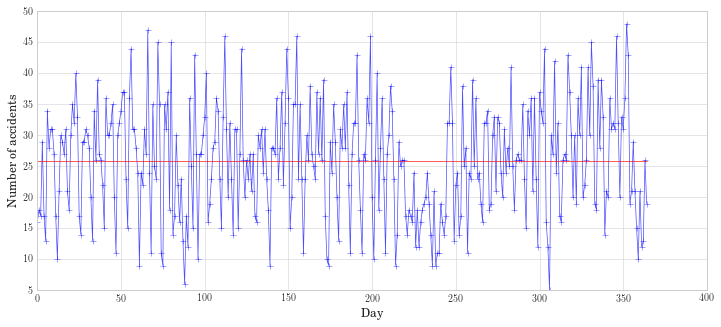

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
plt.ylabel('Number of accidents')
plt.xlabel('Day')
plt.plot(range(0, 365), np.array(accidents), 'b-+', lw=0.7, alpha=0.7)
plt.plot(range(0, 365), [accidents.mean()]*365, 'r-', lw=0.7, alpha=0.9)
plt.show()

Alternatively, we can plot the distribution of our variable of interest: the daily number of accidents.

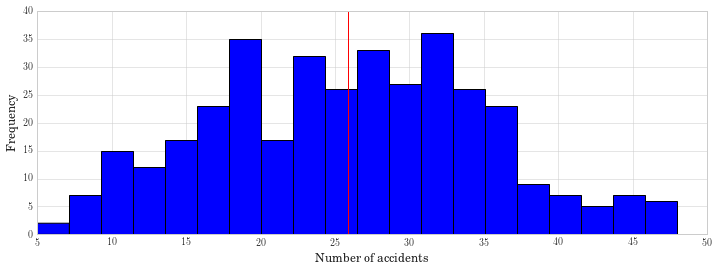

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
plt.ylabel('Frequency')
plt.xlabel('Number of accidents')
plt.hist(np.array(accidents), bins=20)
ax.axvline(x=accidents.mean(), ymin=0, ymax=40, color=[1, 0, 0])
plt.savefig("bootmean.png",dpi=300, bbox_inches='tight')
plt.show()

If we have access to the whole *population*, the computation of the **accident rate** in 2013 is a simple operation: the total number of accidents divided by 365.

In [18]:
print "Mean:", accidents.mean()

Mean: 25.9095890411


But let's suppose that we have only access to a limited part of the data
(the *sample*): the number of accidents during *some days* of 2013. 

In [19]:
df = accidents.to_frame()   
rows = np.random.choice(df.index.values, 200)
sampled_df = df.ix[rows]

+ Compute an approximation of the population mean by using a point estimator of the mean and its standard deviation?

In [ ]:
# Your solution here

In [20]:
est_sigma_mean = sampled_df.std()/math.sqrt(200)

print 'Estimation of the mean from one sample of 200 elements:', sampled_df.mean()[0]
print 'Estimation of SE of the mean from one sample of 200 elements:', est_sigma_mean[0]

Estimation of the mean from one sample of 200 elements: 26.44
Estimation of SE of the mean from one sample of 200 elements: 0.673535634734


+ Use the bootstrapping method for estimating the mesan and its estandard deviation.

In [21]:
!pip install tqdm

You are using pip version 8.1.2, however version 9.0.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [ ]:
# Your solution here

In [22]:
def meanBootstrap(X,numberb):
    import numpy as np
    from tqdm import tqdm
    x = [0]*numberb
    for i in tqdm(range(numberb)):
        sample = [X[_] for _ in np.random.randint(len(X), size=len(X))]
        x[i] = np.mean(sample)
    return x

m = meanBootstrap(np.array(sampled_df[0]), 10000)

100%|█████████████████████████████████| 10000/10000 [00:00<00:00, 17452.01it/s]


In [23]:
print "Mean estimate:", np.mean(m)
print "STD estimate:", np.std(m)

Mean estimate: 26.4416525
STD estimate: 0.66801730647


## Confidence intervals.



A point estimate provides a *single plausible value for a parameter*. However, a point
estimate is rarely perfect; usually there is some error in the estimate. 

Instead of supplying
just a point estimate of a parameter, a next logical step would be to provide *a plausible
range of values* for the parameter.

A plausible range of values for the population parameter is called a **confidence interval**.

Our point estimate is the most plausible value of the parameter, so it makes sense to build
the confidence interval around the point estimate.

If a point estimate distribution is normal, its standard error SE represents the standard deviation associated with the estimate, and we know that roughly 95% of the time the estimate will be within 1.96 standard errors of the parameter.

#### Naive interpretation of the confidence interval

If the interval spreads out 1.96 standard errors from a normally distributed point estimate, intuitively we can say that we are **roughly 95% confident that we have captured the true parameter** (*this is not formally true, see later*).

$$ CI = [\mbox{point estimate} - 1.96 \times SE, \mbox{point estimate} + 1.96 \times SE] $$

**But what does “95% confident” mean?**

<div class = "alert alert-success" style = "border-radius:10px;border-width:3px;border-color:darkgreen;font-family:Verdana,sans-serif;font-size:16px;">
Suppose we took many (infinite) samples and built a confidence
interval from each sample. Then about 95% of those intervals
would contain the actual parameter.
</div>   

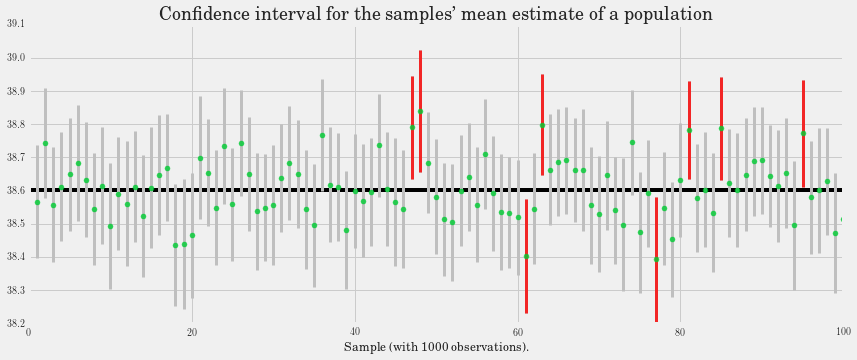

In [24]:
df = firstbirth['prglength']

n = 1000                                              # number of observations
N_test = 100                                          # number of samples with n observations
means = np.array([0.0] * N_test)                      # samples' mean
s = np.array([0.0] * N_test)                          # samples' std
ci = np.array([[0.0,0.0]] * N_test)
tm = df.mean()                                        # "true" mean

for i in range(N_test):                               # sample generation and CI computation
    rows = np.random.choice(df.index.values, n)
    sampled_df = df.ix[rows]
    means[i]=sampled_df.mean()
    s[i]=sampled_df.std()
    ci[i] = means[i] + np.array([-s[i]*1.96/np.sqrt(n), s[i]*1.96/np.sqrt(n)])    

out1 = ci[:,0] > tm                                   # CI that do not contain the "true" mean
out2 = ci[:,1] < tm

with plt.style.context('fivethirtyeight'):            # plot of the CI distribution      
    fig, ax = plt.subplots(1, 1, figsize=(13, 5))
    ind = np.arange(1, N_test+1)
    ax.axhline(y=tm, xmin=0, xmax=N_test+1, color=[0, 0, 0])
    ci = np.transpose(ci)
    ax.plot([ind,ind], ci, color='0.75', marker='_', ms=0, linewidth=3)
    ax.plot([ind[out1], ind[out1]], ci[:, out1], color=[1, 0, 0, 0.8], marker='_', ms=0, linewidth=3)
    ax.plot([ind[out2], ind[out2]], ci[:, out2], color=[1, 0, 0, 0.8], marker='_', ms=0, linewidth=3)
    ax.plot(ind, means, color=[0, .8, .2, .8], marker='.', ms=10, linestyle='')
    ax.set_title("Confidence interval for the samples' mean estimate of a population",
             fontsize=18)
    ax.set_xlabel('Sample (with %d observations). '  %n, fontsize=12)
plt.show()

### Observation

Our reasoning is based on an important result from probability theory that can be directly applied to our problem: the Central Limit Theorem. 

<div class = "alert alert-success" style = "border-radius:10px;border-width:3px;border-color:darkgreen;font-family:Verdana,sans-serif;font-size:16px;"> <b> Central Limit Theorem </b> <br>
If a sample consists of at least 30 independent observations and the data are not
strongly skewed, then the distribution of the sample mean is well approximated by
a normal model.
</div>   

Suppose we want to consider confidence intervals where the confidence level is somewhat
higher than 95%: perhaps we would like a confidence level of 99%.
    
To create a 99% confidence interval, change 1.96 in the 95% confidence interval formula
to be 2.58 (it can be shown that 99% of the time a normal random variable will
be within 2.58 standard deviations of the mean).

In general, if the point estimate follows the normal model with standard error SE, then a
confidence interval for the population parameter is 

$$ \mbox{point estimate} \pm z \times SE_x $$

where $z$ corresponds to the confidence level selected:

| Confidence Level  | z Value  | 
|---|---|
|  90% | 1.65 |
|  95% | 1.96 |
|  99% | 2.58 |
|  99,9% | 3.291 |

### Interpreting confidence intervals

The correct interpretation of a confidence interval is:

> In 95% of the cases, when I compute the confidence interval from a sample, the true mean of the population will fall within $\pm 1.96 \times SE_x$.

**We cannot say neither that our specific sample contains the true parameter nor that the interval has  a 95% chance of containing the true parameter** (parameters are fixed and cannot be the object of a probabilistic statement).

From a logical point of view, given a sample, a point estimate and its CI we can only state that "*the CI contains the true parameter, or not"*. We can also say that if we have access to the population, 95% of the computed CI from samples of $n$ observations will contain the true parameter. 


*Observation: This is not very interesting to say anything about the pregnant lenght of first babies! We have no access to the population and this is the only data we have.*

## Hypothesis testing

Our question is: **Were the observed effects related to the birth of first babies real or not?** 

Technically,  the question is usually translated to: ** Were the observed effects statistically significant**? 

The process of determining the ** statistical significance** of an effect is called **hypothesis testing**.

This process starts by simplifying the options into two competing hypotheses:

+ $H_0$: The mean pregnant lenght for first babies and for other babies is the same (there is only one population, one true mean, and ``first babies`` and ``other babies`` are just different samples from the same population).
+ $H_A$: The mean pregnant lenght for ``first babies`` and for ``other babies`` is different (``first babies`` and ``other babies`` are two samples from two different populations).

We call $H_0$ the **null hypothesis** and it represents a *skeptical* point of view: the effect we have observed is due to chance (due to the specific sample bias). 

$H_A$ is the **alternative hypothesis** and it represents the other point of view: the effect is real.

<div class = "alert alert-success" style = "border-radius:10px;border-width:3px;border-color:darkgreen;font-family:Verdana,sans-serif;font-size:16px;"> <b> Hypothesis Testing </b> <br>
The general rule of frequentist hypothesis testing is: We will not *accept* $H_A$ unless the observed effect is **implausible** under $H_0$.
</div>   

### Testing hypotheses using confidence intervals.

We can use the concept represented by *confidence intervals* to measure the **plausibility** of a hypothesis.

We can start the evaluation of the hypotheses setup by comparing first babies and other babies pregnant lenght using a *point estimate from the first babies sample*: $ \bar{x}_{fb} = 38.6$. 

This estimate suggests the average lenght is actually longer. However, to evaluate
whether this provides strong evidence that there is a difference, we must consider the
uncertainty associated with $ \bar{x}_{fb}$ (The difference between
$\bar{x}_{fb}$ and $ \bar{x}_{ob}$ could be due to sampling variation).

Based on our sample, the 95% confidence interval for the mean pregnant lenght for first babies can be calculated as:

In [25]:
df = firstbirth['prglength']
n = len(df)
mean=df.mean()
s=df.std()
ci = [mean - s*1.96/np.sqrt(n),  mean + s*1.96/np.sqrt(n)] 
print 'Mean:', mean, '| CI of the mean:',ci

Mean: 38.6009517335 | CI of the mean: [38.51857791730805, 38.683325549721175]


Because the other babies' mean, 38.52, falls in the range of plausible values, we cannot say the null hypothesis is **implausible**. 

That is, **we failed to reject the null hypothesis, $H_0$**.

#### Exercise

Implement the evaluation of the hypothesis setup by comparing first babies and other babies pregnant lenght using a 99% confidence interval. Can we reject the null hypothesis, $H_0$? How do you interpret this result?

In [26]:
# Your solution here

In [38]:
# My solution here

df = firstbirth['prglength']
n = len(df)
mean=df.mean()
s=df.std()
ci = [mean - s*2.58/np.sqrt(n),  mean + s*2.58/np.sqrt(n)] 
print mean, ci

# If we increase the confidence level, the effect must be stronger to be accepted.

38.6009517335 [38.492520893814145, 38.70938257321508]


<div class = "alert alert-success" style = "border-radius:10px;border-width:3px;border-color:darkgreen;font-family:Verdana,sans-serif;font-size:16px;">
**Hypothesis tests are not flawless**. We can make a wrong decision in statistical hypothesis tests. 
</div>  

### Interpreting CI tests.

Hypothesis testing is built around rejecting or failing to reject the null hypothesis.
That is, we do not reject $H_0$ unless we have strong evidence. But what precisely does strong
evidence mean? As a general rule of thumb, for those cases where the null hypothesis is
actually true, we do not want to incorrectly reject $H_0$ more than 5% of the time. This
corresponds to a **significance level** of $\alpha =0.05$.

> If we use a 95% confidence interval to test a hypothesis where the null hypothesis is
true, we will make an error whenever the point estimate is at least 1.96 standard errors
away from the population parameter. This happens about 5% of the time (2.5% in each
tail).

## Exercise

Apply the CI method to the mean rate of traffic accidents in Barcelona during 2010 and 2013 using a point estimate from the 2013 sample:

In [ ]:
# Your solution here

In [27]:
data = pd.read_csv("files/ACCIDENTS_GU_BCN_2010.csv", encoding='latin-1')
#Create a new column which is the date
data['Date'] = data['Dia de mes'].apply(lambda x : str(x)) + '-' +  \
               data['Mes de any'].apply(lambda x : str(x))
data2 = data['Date']
counts2010 =data['Date'].value_counts()
print '2010: Mean', counts2010.mean()

data = pd.read_csv("files/ACCIDENTS_GU_BCN_2013.csv", encoding='latin-1')
#Create a new column which is the date
data['Date'] = data['Dia de mes'].apply(lambda x : str(x)) + '-' +  \
               data['Mes de any'].apply(lambda x : str(x))
data2 = data['Date']
counts2013 =data['Date'].value_counts()
print '2013: Mean', counts2013.mean()

2010: Mean 24.8109589041
2013: Mean 25.9095890411


This estimate suggests that during 2013 the mean rate of
traffic accidents in Barcelona **was higher** than 2010. But is this effect statistically significant?

In [28]:
n = len(counts2013)
mean= counts2013.mean()
s= counts2013.std()
ci = [mean - s*1.96/np.sqrt(n),  mean + s*1.96/np.sqrt(n)] 
print '2010 accident rate estimate:', counts2010.mean()
print '2013 accident rate estimate:', counts2013.mean()
print 'CI for 2013:',ci

2010 accident rate estimate: 24.8109589041
2013 accident rate estimate: 25.9095890411
CI for 2013: [24.975156065800284, 26.844022016391499]


Because 2010 accident rate estimate does not fall in the range of plausible values of 2013, we say the
alternative hypothesis cannot be discarted. That is, it can not be discarted that during 2013 the mean rate of traffic accidents in Barcelona was higher than during 2010.

### Testing hypotheses using P-values.

The modern notion of **statistical significance** was developed by R.A.Fisher in the 1920's when looking for a test to decide whether variation in crop yields were due to some specific intervention or merely randon factors beyond experimental control.

Fisher first assumed that fertilizer caused no difference (**null hypothesis**) and then calculated $P$ the probability that an observed yield in a fertilized field would occur if fertilizer had no real effect. This probability is called **p-value**.

<div class = "alert alert-success" style = "border-radius:10px;border-width:3px;border-color:darkgreen;font-family:Verdana,sans-serif;font-size:16px;"> <b> P-value </b> <br>
The p-value is the probability of observing data at least as favorable to the alternative
hypothesis as our current data set, if the null hypothesis is true. We
typically use a summary statistic of the data, f.e. the sample mean, to
help compute the p-value and evaluate the hypotheses.
</div>   

Usually, if $P$ is less than 0.05 (the chance of a fluke is less than 5%) the result is declared **statistically significant**. 

It must be pointed out that this choice is rather arbitrary and should not be taken as a scientific truth.


<div class = "alert alert-success" style = "border-radius:10px;border-width:3px;border-color:darkgreen;font-family:Verdana,sans-serif;font-size:16px;"> <b> www.nature.com, February 13th, 2014 </b> <br>
*For a brief moment in 2010, Matt Motyl was on the brink of scientific glory: 
he had discovered that extremists quite literally see the world in black 
and white.*

*The results were “plain as day”, recalls Motyl, a psychology PhD student at 
the University of Virginia in Charlottesville. Data from a study of nearly 2,000 
people seemed to show that political moderates saw shades of grey more accurately 
than did either left-wing or right-wing extremists. “The hypothesis was sexy,” 
he says, “and the data provided clear support.” The $P$ value, a common index 
for the strength of evidence, was 0.01 — usually interpreted as 'very significant'. 
Publication in a high-impact journal seemed within Motyl's grasp. But...*
</div>

The goal of classical hypothesis testing is to answer the question, “*Given a sample and an apparent effect, what is the probability of seeing such an effect by chance?*”

Here’s how we answer that question:

+ The first step is to quantify the size of the apparent effect by choosing a test statistic. In the NSFG example, the apparent effect is a difference in pregnancy length between first babies and others, so a natural choice for the test statistic is the **difference in means between the two groups**.

+ The second step is to define a **null hypothesis**, which is a model of the system based on the assumption that the apparent effect is not real. In the NSFG example the null hypothesis is that there is no difference between first babies and others; that is, that pregnancy lengths for both groups have the same distribution.

+ The third step is to compute a **p-value**, which is the probability of seeing the apparent effect if the null hypothesis is true. In the NSFG example, we would compute the absolute difference in means, then compute the probability of seeing a difference as big, or bigger, under the null hypothesis.

+ The last step is to **interpret the result**. If the p-value is low, the effect is said to be **statistically significant**, which means that it is unlikely to have occurred by chance. In that case we infer that the effect is more likely to appear in the larger population.

<div class="alert alert-info">A $P$ value is the probability of an observed (or more extreme) result arising only from chance. </div>

If $P$ is less than 0.05 there are two possible conclusions: There is a real effect or the result is an improvable fluke. **Fisher's method offers no way to know which is which**. 

We must not confuse the odds of getting a result (if a hypothesis is true) with the odds of favoring the hypothesis if you observe that result. If $P$ is less than 0.05 we cannot say that this means that it is 95% certain that the observed effect is real and could not have arisen by chance.** $P(E|H)$ and $P(H|E)$ are not the same!** 

Another common error equates **statistical significance** to **practical importance/relevance**. When working with large datasets, we can detect statistical significance for small effects that are meaningless in practical terms. 

### Exercise 

Suppose we toss a coin 250 times and see 140 heads and 110 tails. Based on this result, we might suspect that the coin is biased; that is, more likely to land heads. Compute the p-value of this hypothesis by simulating samples of 250 tossings.

In [40]:
# Your solution here

In [41]:
# My solution

import random
heads, tails = 140,110
test = abs(heads - tails)
n = heads + tails

N = 100000                 # number of samples
diff = range(N)            # array for storing the absolute values of the means' difference

for i in range(N):
    sample = [random.choice('HT') for _ in range(n)]      # sample generation
    h = sample.count('H')                                 # number of H
    t = sample.count('T')                                 # number of T
    diff[i] = abs(h - t)                                  # absolute value of the means' differences

count = sum(1 for i in range(N) if diff[i] >= test)       # counting the number of differences
                                                          # that are more extreme than the observed 
                                                          # effect
print 'P is',float(count)/N
if float(count)/N < 0.05:
    print 'The cannot discard that the coin is biased.'
else:
    print 'There is no evidence of bias'

P is 0.06666
There is no evidence of bias


### Testing a difference in means.

We saw that the mean pregnancy lenght for first babies is slighly longer. Let's see if it is significant.

+ The null hypothesis is that the mean of the two groups is the same and the observed difference is due to chance. 

+ To compute the p-values we can pool the distribution of all live births, generate random samples that are the same size as the observed samples, and compute the difference in means under the null hypothesis.

+ If we generate a large number of samples, we can count how often the difference in means (due to chance) is as big or bigger than the difference we actually observed. This fraction is the p-value.

For pregnancy length, we have the following data: 

In [29]:
m= len(firstbirth['prglength'])
n= len(othersbirth['prglength'])
p = abs(firstbirth['prglength'].mean() - othersbirth['prglength'].mean())
print 'm:',m, 'n:', n
print 'mean difference in weeks: ', p

m: 4413 n: 4735
mean difference in weeks:  0.0780372667775


To approximate the p-value, we can pool the distributions, generate samples with size $m$ and $n$ and compute the difference in the mean.

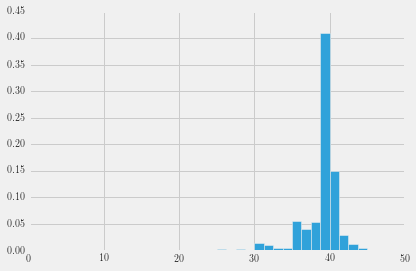

In [30]:
x = firstbirth['prglength']
y = othersbirth['prglength']
pool = np.concatenate([x,y])
np.random.shuffle(pool)

with plt.style.context('fivethirtyeight'):    # plotting the pooled distribution
    plt.hist(pool, bins=40, normed=True)

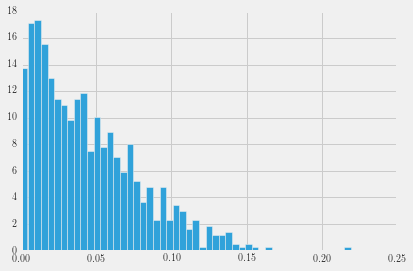

In [31]:
import random
N = 1000                                            # number of samples
diff = range(N)
for i in range(N):
    p1 = [random.choice(pool) for _ in xrange(m)]
    p2 = [random.choice(pool) for _ in xrange(n)]
    diff[i] = abs(np.mean(p1)-np.mean(p2))

with plt.style.context('fivethirtyeight'):          # plotting difference values 
    plt.hist(diff, bins=50, normed=True)

In [32]:
diff2 = np.array(diff)
w1 = np.where(diff2 > p)[0]      # counting how many differences are larger than the observed one
len(w1)

161

If there are $k$ sample pairs where the difference in mean is as big as or bigger than 0.07, the p-value is approximately $k/N$. 

In [33]:
print 'p-value (Simulation)=', len(w1)/float(N), '(', len(w1)/float(N)*100 ,'%)', 'Difference =', p
if len(w1)/float(N)<0.05:
    print 'The effect is likely'
else:
    print 'The effect is not likely'

    
# using python functions

from scipy.stats import ttest_ind
print
print 'P-value original data (Python function):', \
      ttest_ind(firstbirth['prglength'], othersbirth['prglength'])[1]

p-value (Simulation)= 0.161 ( 16.1 %) Difference = 0.0780372667775
The effect is not likely

P-value original data (Python function): 0.167554126394


The most common approach to hypothesis testing is to choose a threshold value for deciding is the effect is likely or not. A common choice is 5% (p-value $< 0.05$). 

So, the effect is not likely!

### Exercise

Compute the p-value for the dataset free of outlier values. What is your opinion about this result? Is this effect **relevant**?

In [34]:
# Your solution here

In [42]:
# My solution

import pandas as pd
df = pd.DataFrame(preg)
df.columns = ['caseid', 'prglength', 'outcome', 'birthord', 'finalwgt']

#data cleaning
df2 = df.drop(df.index[(df.outcome == 1) & (df['prglength'] > df['prglength'].median() + 6)])
df2[(df2.outcome == 1) & (df2['prglength'] > df2['prglength'].median() + 6)]
df3 = df2.drop(df2.index[(df2.outcome == 1) & (df2['prglength'] < df2['prglength'].median() - 10)])
df3[(df3.outcome == 1) & (df3['prglength'] < df3['prglength'].median() - 10)]

firstbirth = df3[(df3.outcome == 1) & (df3.birthord == 1)]
othersbirth = df3[(df3.outcome == 1) & (df3.birthord >= 2)]

m= len(firstbirth['prglength'])
n= len(othersbirth['prglength'])
p = abs(firstbirth['prglength'].mean() - othersbirth['prglength'].mean())
print 'm:',m, 'n:', n
print 'mean difference in weeks: ', p

x = firstbirth['prglength']
y = othersbirth['prglength']
pool = np.concatenate([x,y])
np.random.shuffle(pool)

N = 1000
diff = range(N)
for i in range(N):
    p1 = [random.choice(pool) for _ in xrange(m)]
    p2 = [random.choice(pool) for _ in xrange(n)]
    diff[i] = abs(np.mean(p1)-np.mean(p2))
    
diff2 = np.array(diff)
w1 = np.where(diff2 > p)[0]

print 'p-value =', len(w1)/float(N), '(', len(w1)/float(N)*100 ,'%)', 'Difference =', p
if len(w1)/float(N)<0.05:
    print 'The effect is likely'
else:
    print 'The effect is not likely'
    
print    
print 'P-value clean data (Python function):   ', ttest_ind(firstbirth['prglength'], othersbirth['prglength'])[1]

m: 4351 n: 4681
mean difference in weeks:  0.103930955867
p-value = 0.029 ( 2.9 %) Difference = 0.103930955867
The effect is likely

P-value clean data (Python function):    0.0248872980646


### 5%

But the choice of 5% is arbitrary, and the p-value depends on the choice of the test statistics and the model of the null hypothesis. So p-values should not be considered precise measurements.

p-values can be interpreted according to their order of magnitude: if the p-value is less than 1%, the effect is unlikely to be due to chance; if it is greater than 10%, the effect can plausibly be explained by chance. P-values between 1% and 10% should be considered borderline.

#### One-sided and two-sided tests.

We have defined the effect as *a difference in mean (positive or negative) as big or bigger than $\delta$*, **ignoring the sign**. A test like this is called **two-sided**. 

If the relevant question is whether **pregnancy lengths are different for first babies**, then it makes sense to test the absolute difference in means, but if the hypothesis is that **first babies are likely to be late** we would not take the absolute value of the difference. This kind of test is called one-sided because it only counts one side of the distribution of differences. 

To convert a two-sided test to one-sided text you can multiply the p-value by two and that's it! 

### Confidence intervals of the difference in two means.

The formula for the standard error of the difference in two means is similar to the formula
for other standard errors. Recall that the standard error of a single mean can be
approximated by: 

$$ SE_{\bar{x}_1} = \frac{\sigma_1}{\sqrt{n_1}} $$

The standard error of the difference of two sample means can be constructed from the
standard errors of the separate sample means:

$$ SE_{\bar{x}_1 - \bar{x}_2 } = \sqrt{\frac{\sigma_1^2}{n_1} + \frac{\sigma_2^2}{n_2}} $$

This would allow to define a test with the 95% confidence interval.

### Exercise

Using the birth dataset:

+ Define $H_0$ and $H_1$.
+ Compute the CI of the difference of means for original and clean data.
+ What is your conclusion?

In [35]:
# Your solution here

In [43]:
# My solution (with and without outliers)

# H0 is that the mean of the two groups is the same and the observed difference is due to chance.
# H1 is that the observed difference correspond to two different populations with different means.

import pandas as pd
df = pd.DataFrame(preg)
df.columns = ['caseid', 'prglength', 'outcome', 'birthord', 'finalwgt']

firstbirth = df[(df.outcome == 1) & (df.birthord == 1)]
othersbirth = df[(df.outcome == 1) & (df.birthord >= 2)]

#data cleaning
df2 = df.drop(df.index[(df.outcome == 1) & (df['prglength'] > df['prglength'].median() + 6)])
df2[(df2.outcome == 1) & (df2['prglength'] > df2['prglength'].median() + 6)]
df3 = df2.drop(df2.index[(df2.outcome == 1) & (df2['prglength'] < df2['prglength'].median() - 10)])
df3[(df3.outcome == 1) & (df3['prglength'] < df3['prglength'].median() - 10)]

firstbirthc = df3[(df3.outcome == 1) & (df3.birthord == 1)]
othersbirthc = df3[(df3.outcome == 1) & (df3.birthord >= 2)]

m= len(firstbirth['prglength'])
n= len(othersbirth['prglength'])

mc= len(firstbirthc['prglength'])
nc= len(othersbirthc['prglength'])

import math
diff = abs(firstbirth['prglength'].mean() - othersbirth['prglength'].mean())
SE = math.sqrt( ((firstbirth['prglength'].std()**2)/(m)) + \
                ((othersbirth['prglength'].std()**2)/(n)) )

diffc = abs(firstbirthc['prglength'].mean() - othersbirthc['prglength'].mean())
SEc = math.sqrt( ((firstbirthc['prglength'].std()**2)/(m)) + \
                ((othersbirthc['prglength'].std()**2)/(n)) )


ci = [diff - SE*1.96,  diff + SE*1.96] 
cic = [diffc - SEc*1.96,  diffc + SEc*1.96] 

print 'Outlier data'
print 'Diff:',diff,'CI:', ci
if (0 > ci[0]) and (0 < ci[1]):
    print 'We accept H0.The effect is not likely. '
else:
    print 'We reject H0. The effect is likely. '

print '\n'
print 'Clean data'
print 'Diff:',diffc,'CI:', cic
if (0 > cic[0]) and (0 < cic[1]):
    print 'We accept H0. The effect is not likely.'
else:
    print 'We reject H0. The effect is likely.'    

Outlier data
Diff: 0.0780372667775 CI: [-0.033035012843801545, 0.1891095463989006]
We accept H0.The effect is not likely. 


Clean data
Diff: 0.103930955867 CI: [0.013404419507249216, 0.19445749222646627]
We reject H0. The effect is likely.


### Testing proportions

When we computed relative risk, we saw that first babies are more likely to
be early, less likely to be on time, and more likely to be late.

So maybe the distributions have the same mean and different variance. We
could test the significance of the difference in variance, but variances are less
robust than means, and hypothesis tests for variance often behave badly.

An alternative is to test a hypothesis that more directly reflects the effect as
it appears; that is, **the hypothesis that first babies are more likely to be early,
less likely to be on time, and more likely to be late**.

We proceed in five easy steps:

+ We define a set of categories, called cells, that each baby might fall
into. In this example, there are six cells because there are two groups
(first babies and others) and three bins (early, on time or late).
(We can use the following definitions: a baby is early if it is born
during Week 37 or earlier, on time if it is born during Week 38, 39 or
40, and late if it is born duringWeek 41 or later.)

+ We compute the number of babies we expect in each cell. Under the
null hypothesis, we assume that the distributions are the same for the
two groups, so we can compute the pooled probabilities: $P(early)$,
$P(ontime)$ and $P(late)$. For first babies, we have $n$ = 4413 samples, 
so under the null hypothesis
we expect $n \times P(early)$ first babies to be early, $n \times  P(ontime)$ to be
on time, etc. Likewise, we have $m$ = 4735 other babies, so we expect
$m \times  P(early)$ other babies to be early, etc.

+ For each cell we compute the deviation; that is, the difference between the observed value, 
$O_i$, and the expected value, $E_i$.

+ We compute some measure of the **total deviation**; this quantity is called the test statistic. The most common choice is the **chi-square statistic**:

$$ \chi^2 = \sum_i \frac{(O_i - E_i)^2}{E_i} $$

+ We can use simulation to compute the p-value, which is
the probability of seeing a chi-square statistic as high as the observed
value under the null hypothesis.

When the chi-square statistic is used, this process is called a **chi-square test**.
One feature of the chi-square test is that the distribution of the test statistic
can be computed analytically.

In [36]:
from scipy.stats import chisquare
a = chisquare([16, 18, 16, 14, 12, 12], [16, 16, 16, 16, 16, 16])
print 'Chi-squared test statistic:', a[0], 'P-value of the test', a[1]

Chi-squared test statistic: 2.5 P-value of the test 0.776495071123


### Exercise

Using the data from the NSFG, compute the Chi-squared test statistic and its p-value. 

In [37]:
# Your solution here

In [44]:
# My solution

firstbirthc['Risk'] = 0
firstbirthc['Risk'][firstbirthc['prglength'] < 38] = -1
firstbirthc['Risk'][firstbirthc['prglength'] > 40] = 1

FE = len(firstbirthc[firstbirthc['Risk'] == -1])
FL = len(firstbirthc[firstbirthc['Risk'] == 1])
FO = len(firstbirthc[firstbirthc['Risk'] == 0])

othersbirthc['Risk'] = 0
othersbirthc['Risk'][othersbirthc['prglength'] < 38] = -1
othersbirthc['Risk'][othersbirthc['prglength'] > 40] = 1
OE = len(othersbirthc[othersbirthc['Risk'] == -1])
OL = len(othersbirthc[othersbirthc['Risk'] == 1])
OO = len(othersbirthc[othersbirthc['Risk'] == 0])

n1 = len(firstbirthc['Risk'])
n2 = len(othersbirthc['Risk'])
n = n1+n2
early = (len(firstbirthc[firstbirthc['Risk'] == -1]) + \
         len(othersbirthc[othersbirthc['Risk'] == -1]))/float(n)
late = (len(firstbirthc[firstbirthc['Risk'] == 1]) + \
        len(othersbirthc[othersbirthc['Risk'] == 1]))/float(n)
ontime = (len(firstbirthc[firstbirthc['Risk'] == 0]) + \
          len(othersbirthc[othersbirthc['Risk'] == 0]))/float(n)

mat_obs = [FE, FL, FO, OE, OL, OO]
mat_exp = [int(n1*early), int(n1*late), int(n1*ontime), int(n2*early), int(n2*late), int(n2*ontime)]

from scipy.stats import chisquare
a = chisquare(mat_obs, mat_exp)
print 'Chi-squared test statistic:', a[0], 'P-value of the test', a[1]
if a[1]<0.05:
    print 'We accept the effect.'
else:
    print 'The effect is not significant.'

C:\Users\usuaio\Anaconda2\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
C:\Users\usuaio\Anaconda2\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\usuaio\Anaconda2\lib\site-packages\pandas\core\generic.py:4428: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
C:\Users\usuaio\Anaconda2\lib

Chi-squared test statistic: 91.3539149012 P-value of the test 3.49012729216e-18
We accept the effect.


### Frequentist general inference: Conclusions.

+ Point estimates are useful to build hypotheses.
+ We can measure the variability of PE with SE or 95% confidence intervals.
+ We produce a proposition by computing $P(E|H_0)$ (by setting $\alpha$ in advance):
    + Accept $H_1$ if $P(E|H_0) < \alpha$.
    + Accept $H_0$ if $P(E|H_0) \geq \alpha$.

### But, is the effect $E$ real?

We have yet no answer for this question! We have defined a null hypothesis $H_0$ (the effect is not real), which is $P(E | H_0)$, where $E$ is an effect as big as or bigger than the aparent effect and a p-value. 

We have stated that under the frequentist point of view, we cannot accept $H_A$ unless $P(E | H_0)$ is less than an arbitrary value. But, what happens if $P(H_A | E) > P(H_0 | E)$?

One possible solution to these problems is to use **Bayesian reasoning**, an alternative to the frequentist apporach.

<div class = "alert alert-success" style = "border-radius:10px;border-width:3px;border-color:darkgreen;font-family:Verdana,sans-serif;font-size:16px;"> **Big Data accelerates medical research? Or not?**  KDNuggets, 2014. <br>

A recent study looked at over 4 dozen health claims that researchers arrived at by examining existing data for possible associations - not by conducting controlled experiments.  These 4 dozen claims all had one thing in common - they were tested later by controlled experiments.  Astonishingly, not one of the claims held up in the controlled experiment. <br>

Various reasons have been posited for the parlous state of scientific and medical research, including **fraud and outright error**, but a key issue is what statisticians call the "**multiple comparisons problem**."  Even in completely randomly-generated data, interesting patterns appear.  If the data are big enough and the search exhaustive enough, the patterns can be very compelling. <br>
The moral?  Rapid growth in the digitization and availability of patient data and health data in general holds great potential for medical research and personalized medicine.  However, appropriate statistical methodology and sound study design are needed to unlock this potential, and guard against error. 
</div>

### The skeptic view

No matter how much data you have, you will still depend on intuition to decide how to interpret, explain and use the data.

Data can’t say anything. Data scientists are interpreters, offering one interpretation of what the useful narrative story derived from the data is (if there is one at all).

Cognitive Bias (f.e. confirmation bias, narrative bias) pollutes our view of data. 

